In [92]:

import requests
import lxml.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [93]:

def get_info(link:str) -> list:
    url =link
    get_info = requests.get(url)
    info = eval(get_info.text)
    datalist=info['value']
    data=pd.DataFrame(datalist)
    #country = info['value']
    return data

In [94]:
def Integrity_Check(df):
    print('Is there any null value in the dataset')
    print(df.isna().all().all())
    print('Every year has all country data?')
    print(df.groupby(['DIM_YEAR_CODE'])['DIM_COUNTRY_CODE'].nunique())
    print('which country provide more data?')
    print(df.groupby(['DIM_COUNTRY_CODE'])['DIM_YEAR_CODE'].count().sort_values(ascending=False))
    print('How many cause of death in the dataset? Any herirarchy?')
    print(list[df['DIM_GHECAUSE_TITLE'].unique()])
    print('which cause of death has more country data? ')
    print(df.groupby(['DIM_GHECAUSE_TITLE'])['DIM_COUNTRY_CODE'].nunique().sort_values(ascending=False))

In [105]:
def dataframe_intergration(df):
    df['COUNTRY_NAME']=None
    df['INCOME_GROUP']=None
    df['REGION']=None
    df['mortality_type']=None
    df['INCOME_GROUP_LEVEL']=None
    df['DIM_GHECAUSE_CODE']=df['DIM_GHECAUSE_CODE'].astype('int')
    df['DIM_YEAR_CODE']=df['DIM_YEAR_CODE'].astype('int')
    income=pd.read_csv("income groupyyy.csv",encoding='ansi')
    region=pd.read_csv("country_region.csv")

    country_list=list(df.DIM_COUNTRY_CODE.unique())

    for country in country_list:
        for year in range(2000,2020):
            #print(country,year)
            income_group=income.loc[income['cty_code'] == country, str(year)].tolist()
            country_name=income.loc[income['cty_code'] == country, 'country'].tolist()
            df.loc[(df['DIM_COUNTRY_CODE']==country) & (df['DIM_YEAR_CODE']==year),'INCOME_GROUP']=income_group[0]
            df.loc[(df['DIM_COUNTRY_CODE']==country) & (df['DIM_YEAR_CODE']==year),'COUNTRY_NAME']=country_name[0]
    countryname_list=list(df.COUNTRY_NAME.unique())
    for country in countryname_list:
        belong_region=region.loc[region['Country']==country,'Region'].tolist()
        #print(country,belong_region)
        try:
            df.loc[df['COUNTRY_NAME']==country,'REGION']=belong_region[0]
        except:
            continue

    df.loc[df['DIM_GHECAUSE_CODE']<600,'mortality_type']='communicable'
    df.loc[(df['DIM_GHECAUSE_CODE']>600) & (df['DIM_GHECAUSE_CODE']<1510),'mortality_type']='noncommunicable'
    df.loc[df['DIM_GHECAUSE_CODE']>1510,'mortality_type']='Injuries'

    # for the correlation, transform the income_group(str) to income_group_level(int)
    df.loc[df['INCOME_GROUP']=='H','INCOME_GROUP_LEVEL']=4
    df.loc[df['INCOME_GROUP']=='UM','INCOME_GROUP_LEVEL']=3
    df.loc[df['INCOME_GROUP']=='LM','INCOME_GROUP_LEVEL']=2
    df.loc[df['INCOME_GROUP']=='L','INCOME_GROUP_LEVEL']=1
    df.loc[df['INCOME_GROUP']=='..','INCOME_GROUP_LEVEL']=0
    df['INCOME_GROUP_LEVEL']=df['INCOME_GROUP_LEVEL'].astype('int')
    return df

In [96]:
def world_mortality_trend(all_data):
    worldly_mortality_trend=all_data.groupby(['DIM_YEAR_CODE','DIM_COUNTRY_CODE'])[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    worldly_mortality_trend.reset_index()
    worldly=worldly_mortality_trend.groupby(['DIM_YEAR_CODE'])[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    worldly['death_per1000']=worldly['VAL_DEATHS_COUNT_NUMERIC']/worldly['ATTR_POPULATION_NUMERIC']*1000
    worldly=worldly.reset_index()
    fig = plt.figure(figsize = (14,7))
    plt.plot(worldly['DIM_YEAR_CODE'], # x轴数据
         worldly['death_per1000'], # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
         color = 'steelblue', # 折线颜色

         markeredgecolor='black', # 点的边框色
         markerfacecolor='brown') # 点的填充色

    plt.title('World-wide mortality rate')
    plt.xlabel('Year')
    plt.ylabel('rate( per 1000 population)')
    plt.ylim((4, 10))

    return worldly

In [119]:
def ratetrend_incomegroup(dataset):#done
    causebyincome=dataset.sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['INCOME_GROUP','DIM_YEAR_CODE','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC','INCOME_GROUP_LEVEL']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum,'INCOME_GROUP_LEVEL':np.max})
    causebyincome=causebyincome.groupby(['INCOME_GROUP','DIM_YEAR_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC','INCOME_GROUP_LEVEL']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum,'INCOME_GROUP_LEVEL':np.max})
    causebyincome['death_per1000']=causebyincome['VAL_DEATHS_COUNT_NUMERIC']/causebyincome['ATTR_POPULATION_NUMERIC']*1000

    return causebyincome

In [122]:
def Topdeathtype_incomegroup_year(dataset,  year):   #done
    causebyincome=dataset[(dataset['DIM_YEAR_CODE']==year)].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['INCOME_GROUP','mortality_type','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum})

    causebyincome1=causebyincome.groupby(['INCOME_GROUP','mortality_type'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    causebyincome1['death_per1000']=causebyincome1['VAL_DEATHS_COUNT_NUMERIC']/causebyincome1['ATTR_POPULATION_NUMERIC']*1000
    causebyincome1 = causebyincome1.pivot(index='INCOME_GROUP', columns='mortality_type', values='death_per1000')
    colors = ["#006D2C", "#31A354","#74C476"]
    causebyincome1.loc[:,['Injuries','communicable', 'noncommunicable']].plot.bar(stacked=True, color=colors, figsize=(10,7),ylim=([0,10]))
    return causebyincome1

In [171]:
def Topcause_trend_incomegroup(dataset,income_group,diseaselist):
    causebyincome=dataset[(dataset['INCOME_GROUP']==income_group)&(dataset['DIM_GHECAUSE_TITLE'].isin(diseaselist))].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['DIM_GHECAUSE_TITLE','DIM_YEAR_CODE'],as_index=False)[['VAL_DEATHS_COUNT_NUMERIC']].agg({'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    causebyincome1 = causebyincome.pivot(index='DIM_YEAR_CODE', columns='DIM_GHECAUSE_TITLE', values='VAL_DEATHS_COUNT_NUMERIC')
    causebyincome1.plot(kind='line', xlabel='year',ylabel='the number of death ',
                 title='death trend from 2000-2019',
                 figsize=(6, 4.5),legend=True)

    return causebyincome

In [164]:
def Topcause_incomegroup_year(dataset,income_group,  year):
    causebyincome=dataset[(dataset['DIM_YEAR_CODE']==year)&(dataset['INCOME_GROUP']==income_group)].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['DIM_GHECAUSE_TITLE'],as_index=False)[['VAL_DEATHS_COUNT_NUMERIC']].agg({'VAL_DEATHS_COUNT_NUMERIC': np.sum}).nlargest(5,'VAL_DEATHS_COUNT_NUMERIC')
    #worldly_mortality_trend['death_rate']=worldly_mortality_trend['VAL_DEATHS_COUNT_NUMERIC']/worldly_mortality_trend['ATTR_POPULATION_NUMERIC']
    #worldly_mortality_trend.reset_index()
    #worldly=worldly_mortality_trend.groupby(['DIM_YEAR_CODE'])[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    #worldly['death_rate']=worldly['VAL_DEATHS_COUNT_NUMERIC']/worldly['ATTR_POPULATION_NUMERIC']*1000
    #worldly=worldly.reset_index()
    return causebyincome

In [124]:
def deathtypetrend_incomegroup(dataset, income_group):
    causebyincome=dataset[dataset['INCOME_GROUP']==income_group].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['DIM_YEAR_CODE','mortality_type','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum})

    causebyincome1=causebyincome.groupby(['DIM_YEAR_CODE','mortality_type'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    causebyincome1['death_per1000']=causebyincome1['VAL_DEATHS_COUNT_NUMERIC']/causebyincome1['ATTR_POPULATION_NUMERIC']*1000
    causebyincome1 = causebyincome1.pivot(index='DIM_YEAR_CODE', columns='mortality_type', values='death_per1000')
    causebyincome1.plot(kind='line', xlabel='year',ylabel='death_per1000 ',
                 title='death rate trend from 2000-2019 by different cause of death',
                 figsize=(6, 4.5),legend=True)
    return causebyincome1

In [106]:
all_data=get_info('https://frontdoor-l4uikgap6gz3m.azurefd.net/DEX_CMS/GHE_FULL?&$orderby=VAL_DEATHS_RATE100K_NUMERIC%20desc&$select=DIM_COUNTRY_CODE,DIM_GHECAUSE_CODE,DIM_GHECAUSE_TITLE,DIM_YEAR_CODE,DIM_SEX_CODE,DIM_AGEGROUP_CODE,VAL_DALY_COUNT_NUMERIC,VAL_DEATHS_COUNT_NUMERIC,ATTR_POPULATION_NUMERIC,VAL_DALY_RATE100K_NUMERIC,VAL_DEATHS_RATE100K_NUMERIC&$filter=FLAG_RANKABLE%20eq%201%20and%20DIM_SEX_CODE%20eq%20%27BTSX%27%20and%20DIM_AGEGROUP_CODE%20eq%20%27ALLAges%27')
#all_data.to_csv('all_data.csv',sep=',', index=False)
dataframe_intergration(all_data)
Integrity_Check(all_data)
# Dataset doesnt have null value, Every country(number of countries:183) has value in each year (year range:2000-2019)

Is there any null value in the dataset
False
Every year has all country data?
DIM_YEAR_CODE
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    183
2014    183
2015    183
2016    183
2017    183
2018    183
2019    183
Name: DIM_COUNTRY_CODE, dtype: int64
which country provide more data?
DIM_COUNTRY_CODE
RUS    927
SOM    901
CAF    884
UKR    879
LTU    879
      ... 
SAU    370
BHR    351
ARE    319
QAT    285
KWT    261
Name: DIM_YEAR_CODE, Length: 183, dtype: int64
How many cause of death in the dataset? Any herirarchy?
list[array(['Natural disasters', 'HIV/AIDS', 'Ischaemic heart disease',
       'Collective violence and legal intervention', 'Stroke', 'Malaria',
       'Diarrhoeal diseases', 'Lower respiratory infections', 'Measles',
       'Hypertensive heart disease',
       'Cardiomyopathy, myocarditis, endocarditis',
       'Protein-energy malnutrition', 'Neonatal c

,DIM_YEAR_CODE,ATTR_POPULATION_NUMERIC,VAL_DEATHS_COUNT_NUMERIC,death_per1000
0,2000,6.116994e+09,45387904.74,7.419969
1,2001,6.197259e+09,45587156.12,7.356020
2,2002,6.260956e+09,46009360.66,7.348616
3,2003,6.343724e+09,46220884.71,7.286081
4,2004,6.426602e+09,45919133.15,7.145165
5,2005,6.510923e+09,45712089.62,7.020831
6,2006,6.597804e+09,45309802.67,6.867406
7,2007,6.663735e+09,45261094.74,6.792151
8,2008,6.751347e+09,45671698.34,6.764827
9,2009,6.840801e+09,45021032.21,6.581251


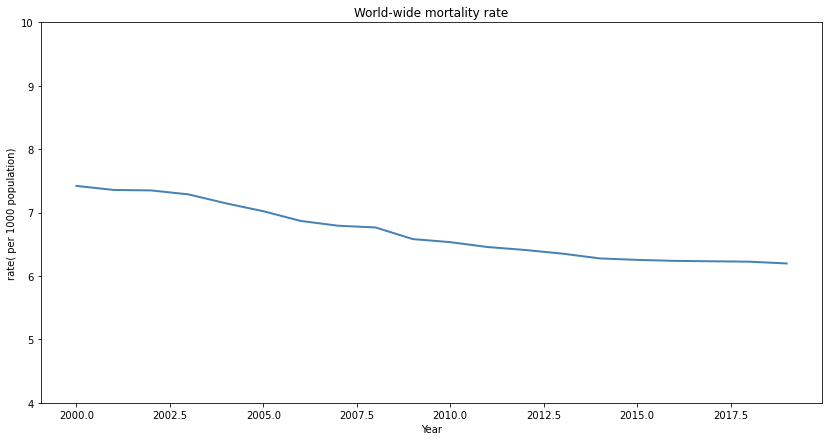

In [76]:
world_mortality_trend(all_data)
#it shows that the world-wide death rate is getting lower.

   INCOME_GROUP  DIM_YEAR_CODE  ATTR_POPULATION_NUMERIC  \
0            ..           2000             1.718493e+07   
1            ..           2001             1.647173e+07   
2            ..           2002             1.664806e+07   
3            ..           2003             1.684198e+07   
4            ..           2004             1.707113e+07   
..          ...            ...                      ...   
86           UM           2015             2.628688e+09   
87           UM           2016             2.613417e+09   
88           UM           2017             2.613893e+09   
89           UM           2018             2.703211e+09   
90           UM           2019             2.901398e+09   

    VAL_DEATHS_COUNT_NUMERIC  INCOME_GROUP_LEVEL  death_per1000  
0                  192266.88                   0      11.188108  
1                  179351.70                   0      10.888456  
2                  182146.11                   0      10.940981  
3                  182646.4

'it shows that the correlation between income group and death rate, the cor= -0.57, means the the high income country has a higher death rate\nBeside, the chart provide the death rate trend in different income group\n'

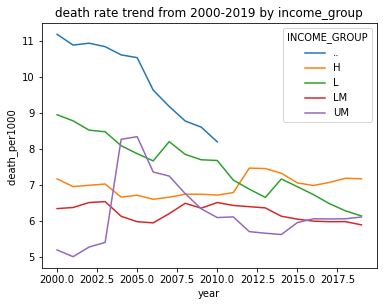

In [118]:
d=ratetrend_incomegroup(all_data)
print(d)
print(d.corr())
plotdata=d.pivot(index='DIM_YEAR_CODE', columns='INCOME_GROUP', values='death_per1000')
plotdata.plot(kind='line', xlabel='year',ylabel='death_per1000 ',
                 title='death rate trend from 2000-2019 by income_group',
                 figsize=(6, 4.5),legend=True)

'''it shows that the correlation between income group and death rate, the cor= -0.57, means the the high income country has a higher death rate
Beside, the chart provide the death rate trend in different income group
two interesting trend that we can discuss later:
1.upper middle group has a peak around 2005, what happened?
2.there is a clear declined trend of LOW income country, what led to this trend?
'''

2004
2019


mortality_type,Injuries,communicable,noncommunicable
INCOME_GROUP,,,
H,0.358516,0.385890,6.429425
L,0.612357,3.116340,2.411942
LM,0.453818,1.787117,3.652690
UM,0.428582,0.462524,5.220398


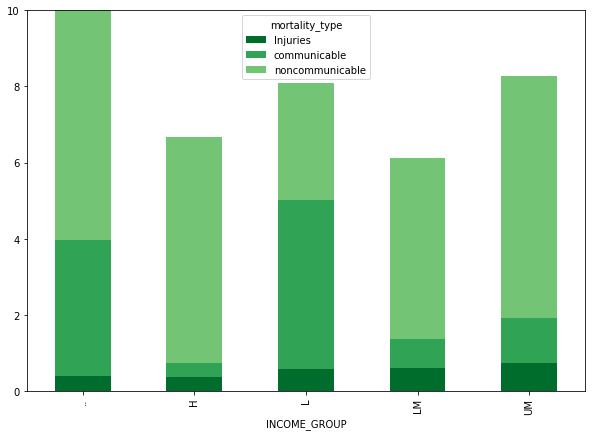

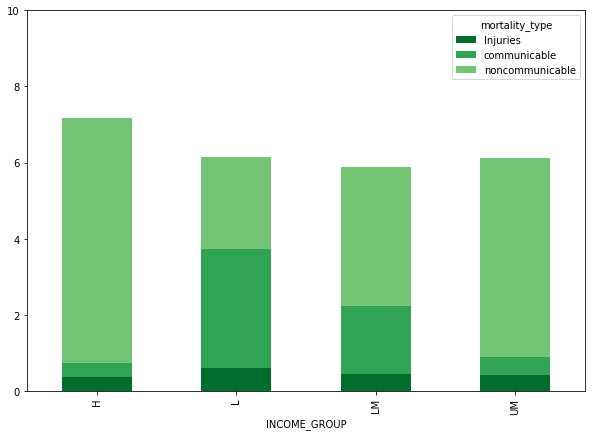

In [128]:

print('2004')
Topdeathtype_incomegroup_year(all_data,2004)

print('2019')
Topdeathtype_incomegroup_year(all_data,2019)
'''there death types, it matched the paper1:
1. When in 2004, Communicable diseases remain an important cause of death in lowincome countries.
2. Confirm the growing importance of noncommunicable diseases in most low- and middle-income countries.'''

low income
upper middle income


mortality_type,Injuries,communicable,noncommunicable
DIM_YEAR_CODE,,,
2000,0.511668,0.993761,3.691657
2001,0.500654,0.682185,3.826593
2002,0.427918,0.581588,4.268600
2003,0.434560,0.589462,4.380186
2004,0.744998,1.170118,6.356096
2005,0.711665,1.161770,6.469938
2006,0.677611,1.018903,5.666164
2007,0.656542,0.974944,5.617562
2008,0.635425,0.893169,5.231713


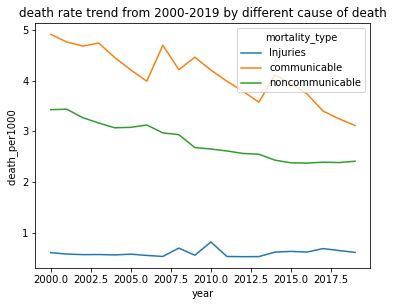

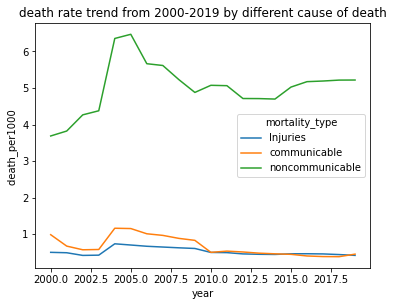

In [173]:
print('low income')
deathtypetrend_incomegroup(all_data,'L')
print('upper middle income')
deathtypetrend_incomegroup(all_data,'UM')
#print('lower middle income')
#deathtypetrend_incomegroup(all_data,'LM')

In [166]:
print(Topcause_incomegroup_year(all_data,'L',2019))
print(Topcause_incomegroup_year(all_data,'L',2004))
topcause_low_2019=Topcause_incomegroup_year(all_data,'L',2019)
disease_list=list(topcause_low_2019['DIM_GHECAUSE_TITLE'])

'''As may be expected from the very different distributions of deaths by
age and sex, there are major differences in the ranking of causes
between high- and low-income countries (Table 4). In low-income
countries, the dominant causes are infectious and parasitic diseases
(including malaria), and neonatal causes. In the high-income countries,
9 of the 10 leading causes of death are non-communicable conditions,
including the four types of cancer. In the middle-income countries, the
10 leading causes of death are again dominated by non-communicable
conditions; they also include road traffic accidents as the sixth most
common cause.'''

              DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC
42           Neonatal conditions                 518673.65
35  Lower respiratory infections                 416363.01
30       Ischaemic heart disease                 379461.12
59                        Stroke                 334008.76
17           Diarrhoeal diseases                 262530.58
              DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC
46           Neonatal conditions                2282097.77
19           Diarrhoeal diseases                1985220.41
32       Ischaemic heart disease                1719989.17
37  Lower respiratory infections                1712520.72
64                        Stroke                1362827.50


'As may be expected from the very different distributions of deaths by\nage and sex, there are major differences in the ranking of causes\nbetween high- and low-income countries (Table 4). In low-income\ncountries, the dominant causes are infectious and parasitic diseases\n(including malaria), and neonatal causes. In the high-income countries,\n9 of the 10 leading causes of death are non-communicable conditions,\nincluding the four types of cancer. In the middle-income countries, the\n10 leading causes of death are again dominated by non-communicable\nconditions; they also include road traffic accidents as the sixth most\ncommon cause.'

,DIM_GHECAUSE_TITLE,DIM_YEAR_CODE,VAL_DEATHS_COUNT_NUMERIC
0,Diarrhoeal diseases,2000,2472552.50
1,Diarrhoeal diseases,2001,2388380.72
2,Diarrhoeal diseases,2002,2325186.90
3,Diarrhoeal diseases,2003,2128325.51
4,Diarrhoeal diseases,2004,1985220.41
...,...,...,...
95,Stroke,2015,308453.67
96,Stroke,2016,315058.22
97,Stroke,2017,345543.41
98,Stroke,2018,340979.57


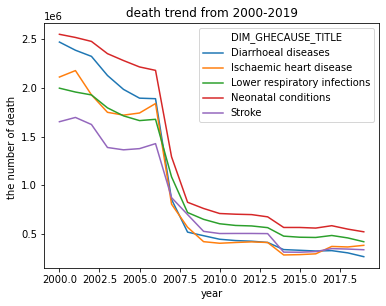

In [172]:
Topcause_trend_incomegroup(all_data,'L',disease_list)